# Tải thư viện và dữ liệu

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("aceus2807/weather-prediction-rnn-and-cnn")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/weather-prediction-rnn-and-cnn


In [3]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassificationModel
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.functions import lag, col, lead
from pyspark.sql.window import Window
import os

In [4]:
# Initialize SparkSession
spark = SparkSession.builder.appName("RainPredictionTuning").config("spark.memory.offHeap.enabled", "true").config("spark.memory.offHeap.size", "10g").getOrCreate()

In [5]:
df = spark.read.csv(path + "/weather_dataset.csv", header=True, inferSchema=True)

In [6]:
df.show(5)

+-------------+-------+----+--------+----------------+-------------------+----------+-------------------+------+------+------+--------------+--------+--------+-----------+--------+-----------+-----------+---------+---------+--------+-----+-----------+-----------+-----------+-----------+-----------+-----------+----------+----------+------+---------+---+--------+--------+------------+--------------+
|location_name|country| lat|     lon|           tz_id|          localtime|      date|               time|temp_c|temp_f|is_day|condition_text|wind_mph|wind_kph|wind_degree|wind_dir|pressure_mb|pressure_in|precip_mm|precip_in|humidity|cloud|feelslike_c|feelslike_f|windchill_c|windchill_f|heatindex_c|heatindex_f|dewpoint_c|dewpoint_f|vis_km|vis_miles| uv|gust_mph|gust_kph|will_it_rain|chance_of_rain|
+-------------+-------+----+--------+----------------+-------------------+----------+-------------------+------+------+------+--------------+--------+--------+-----------+--------+-----------+------

In [7]:
df = df.drop('country','lat','lon','date','tz_id','localtime','temp_f','wind_kph', 'feelslike_f','pressure_in','heatindex_f','precip_in','windchill_f', 'dewpoint_f','vis_miles','gust_kph','chance_of_rain')

In [8]:
df.columns

['location_name',
 'time',
 'temp_c',
 'is_day',
 'condition_text',
 'wind_mph',
 'wind_degree',
 'wind_dir',
 'pressure_mb',
 'precip_mm',
 'humidity',
 'cloud',
 'feelslike_c',
 'windchill_c',
 'heatindex_c',
 'dewpoint_c',
 'vis_km',
 'uv',
 'gust_mph',
 'will_it_rain']

# Chọn các đặc trưng có tương quan cao

In [9]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, stddev
from pyspark.sql.types import StringType
import pyspark.sql.functions as F
from scipy import stats

# Selecting categorical columns
categorical_columns = [field.name for field in df.schema.fields if isinstance(field.dataType, StringType)]

# # Function to calculate ANOVA F-statistic and p-value
# def anova_test(df, categorical_column, numerical_column='will_it_rain'):
#     categories = df.select(categorical_column).distinct().rdd.flatMap(lambda x: x).collect()
#     if len(categories) < 2:
#         return None

#     # Use pandas for more efficient calculations
#     pandas_df = df.toPandas()

#     # Calculating the overall mean
#     overall_mean = pandas_df[numerical_column].mean()

#     # Calculating the within-group and between-group sum of squares
#     sum_squares_between = 0
#     sum_squares_within = 0

#     for cat in categories:
#         group_data = pandas_df[pandas_df[categorical_column] == cat]
#         group_mean = group_data[numerical_column].mean()
#         group_count = len(group_data)

#         sum_squares_between += group_count * (group_mean - overall_mean)**2
#         sum_squares_within += group_data[numerical_column].var() * (group_count - 1)

#     # Degrees of freedom
#     df_between = len(categories) - 1
#     df_within = len(pandas_df) - len(categories)

#     # Calculating the F-statistic and p-value
#     mean_square_between = sum_squares_between / df_between
#     mean_square_within = sum_squares_within / df_within
#     f_statistic = mean_square_between / mean_square_within
#     p_value = 1 - stats.f.cdf(f_statistic, df_between, df_within)

#     return (categorical_column, f_statistic, p_value)

def anova_test(df, categorical_column, numerical_column='will_it_rain'):
    # Get distinct categories
    categories = df.select(categorical_column).distinct().rdd.flatMap(lambda x: x).collect()

    # Filter categories with at least 2 observations
    valid_categories = [
        cat for cat in categories
        if df.filter(col(categorical_column) == cat).count() >= 2
    ]

    # If fewer than 2 valid categories, return None
    if len(valid_categories) < 2:
        return None

    # Calculate overall mean
    overall_mean = df.select(mean(numerical_column)).collect()[0][0]

    # Calculate between-group sum of squares
    sum_squares_between = sum([
        df.filter(col(categorical_column) == cat).count() *
        (df.filter(col(categorical_column) == cat).select(mean(numerical_column)).collect()[0][0] - overall_mean) ** 2
        for cat in valid_categories
    ])

    # Calculate within-group sum of squares
    sum_squares_within = 0
    for cat in valid_categories:
        group_variance = df.filter(col(categorical_column) == cat).select(F.variance(numerical_column)).collect()[0][0]
        group_count = df.filter(col(categorical_column) == cat).count()
        # Handle null or zero variance
        if group_variance is not None and group_variance > 0:
            sum_squares_within += group_variance * (group_count - 1)

    # Degrees of freedom
    df_between = len(valid_categories) - 1
    df_within = df.count() - len(valid_categories)

    # Calculate F-statistic and p-value
    mean_square_between = sum_squares_between / df_between if df_between > 0 else 0
    mean_square_within = sum_squares_within / df_within if df_within > 0 else 0

    # Avoid division by zero
    if mean_square_within == 0:
        return (categorical_column, float('inf'), 0.0)  # Indicate high significance or invalid test

    f_statistic = mean_square_between / mean_square_within
    p_value = 1 - stats.f.cdf(f_statistic, df_between, df_within) if f_statistic > 0 else 1.0

    return (categorical_column, float(f_statistic), float(p_value))

# Applying ANOVA test for each categorical column
anova_results = [anova_test(df, column) for column in categorical_columns if anova_test(df, column) is not None]
# Convert results to Spark DataFrame
anova_results_converted = [(col, float(f_stat), float(p_val)) for col, f_stat, p_val in anova_results]

# Define the schema
from pyspark.sql.types import StructType, StructField, FloatType, StringType

# Create DataFrame using the converted results
schema = StructType([
    StructField("Column", StringType(), True),
    StructField("F-statistic", FloatType(), True),
    StructField("P-value", FloatType(), True)
])

anova_df = spark.createDataFrame(anova_results_converted, schema)

# Filter and Sort Results
significant_results = anova_df.filter(col('P-value') <= 0.05).sort('F-statistic', ascending=False)

# Show Results
significant_results.show()

+--------------+-----------+------------+
|        Column|F-statistic|     P-value|
+--------------+-----------+------------+
|condition_text|   993400.1|1.110223E-16|
|      wind_dir|  702.22906|1.110223E-16|
| location_name|  82.591415|1.110223E-16|
+--------------+-----------+------------+



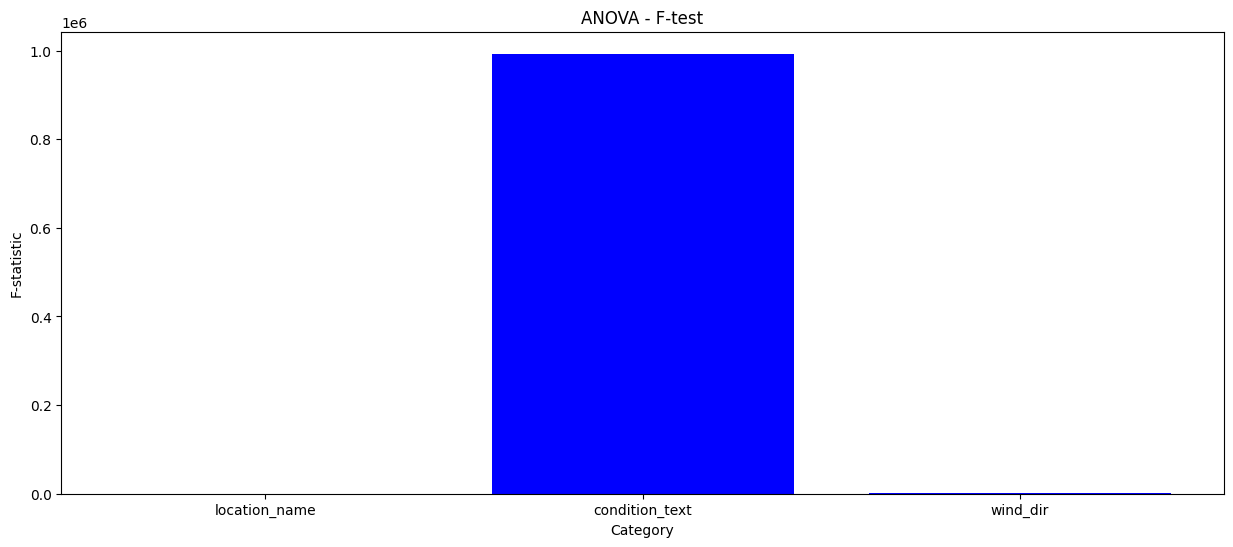

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert the ANOVA results list to a DataFrame
anova_df = pd.DataFrame(anova_results, columns=['Column', 'F-statistic', 'P-value'])

# Vẽ biểu đồ cột cho F-statistic
plt.figure(figsize=(15, 6))
plt.bar(anova_df['Column'], anova_df['F-statistic'], color='blue')
plt.title('ANOVA - F-test')
plt.xlabel('Category')
plt.ylabel('F-statistic')
plt.show()

In [11]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import FloatType
from scipy import stats

def find_significant_vars_spark(df, target_var, alpha=0.05):
    numeric_vars = [col_name for col_name, data_type in df.dtypes if data_type in ['double', 'int']]
    numeric_vars.remove(target_var)

    significant_vars = []

    for var in numeric_vars:
        correlation = df.stat.corr(var, target_var)
        p_value = stats.pearsonr(df.select(var).rdd.flatMap(lambda x: x).collect(),
                                 df.select(target_var).rdd.flatMap(lambda x: x).collect())[1]

        if p_value < alpha:
            significant_vars.append({
                'Column': var,
                'F-statistic': correlation,
                'P-value': p_value
            })

    return significant_vars

find_significant_vars_spark(df, 'will_it_rain')
# Gọi hàm và lưu kết quả vào một biến
significant_vars_output = find_significant_vars_spark(df, 'will_it_rain')

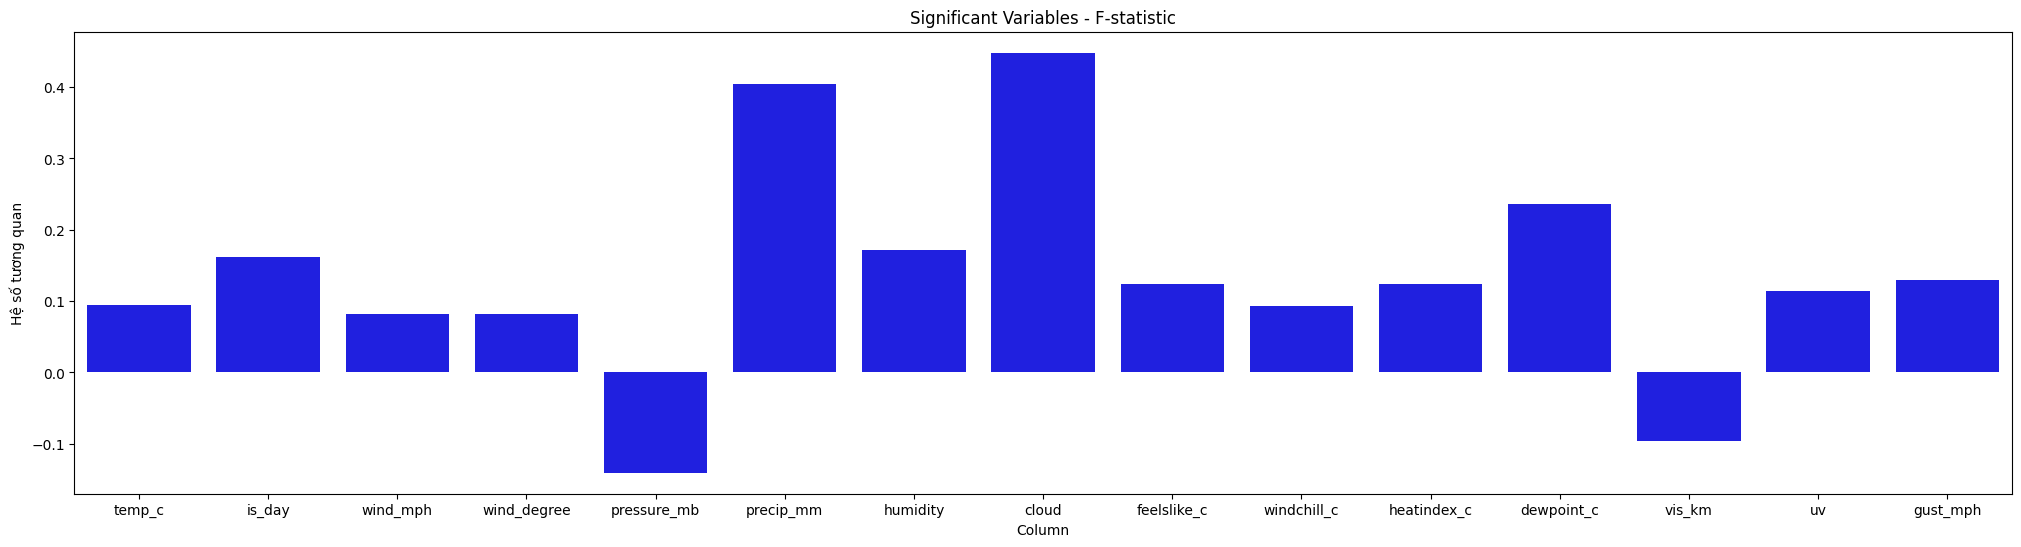

In [12]:
# Tạo DataFrame từ kết quả
significant_variables_df = pd.DataFrame(significant_vars_output)

# Vẽ biểu đồ
plt.figure(figsize=(25, 6))
sns.barplot(x='Column', y='F-statistic', data=significant_variables_df, color='blue')
plt.title('Significant Variables - F-statistic')
plt.ylabel('Hệ số tương quan')
plt.show()

In [13]:
# Index categorical columns
indexer = StringIndexer(inputCol='condition_text', outputCol='conditionid')
df = indexer.fit(df).transform(df)

In [14]:
# Convert time to timestamp
df = df.withColumn("time", col("time").cast("timestamp"))

In [15]:
# Create lagged features and target
window_spec = Window.partitionBy("location_name").orderBy("time")

# Keep only the current features (no lagging needed for current hour prediction)
current_features = ["precip_mm", "cloud", "dewpoint_c", "conditionid"]

# Create 24 target variables for the next 24 hours
for i in range(1, 25):
    df = df.withColumn(f"will_it_rain_hour_{i}", lead(col("will_it_rain"), i).over(window_spec))

# Select the current features and the 24 target variables
selected_cols = current_features + [f"will_it_rain_hour_{i}" for i in range(1, 25)]
df = df.select(selected_cols)

df = df.na.drop()

In [16]:
df.show()

+---------+-----+----------+-----------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|precip_mm|cloud|dewpoint_c|conditionid|will_it_rain_hour_1|will_it_rain_hour_2|will_it_rain_hour_3|will_it_rain_hour_4|will_it_rain_hour_5|will_it_rain_hour_6|will_it_rain_hour_7|will_it_rain_hour_8|will_it_rain_hour_9|will_it_rain_hour_10|will_it_rain_hour_11|will_it_rain_hour_12|will_it_rain_hour_13|will_it_rain_hour_14|will_it_rain_hour_15|will_it_rain_hour_16|will_it_rain_hour_17|will_it_rain_hour_18|will_it_rain_hour_19|will_it_rain_hour_20|will_it_rain_

In [17]:
# prompt: Tạo cho tôi 1 cột columns là will_it_rain_24h. Nếu các giá trị của will_it_rain_hour_1 cho đến will_it_rain_hour_24 tồn tại 1 thì will_it_rain_24h là 1. Ngược lại will_it_rain_24h là 0

df = df.withColumn("will_it_rain_24h",
  (sum([col(f"will_it_rain_hour_{i}") for i in range(1, 25)]) > 0).cast("integer"))

df.show()

+---------+-----+----------+-----------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------+
|precip_mm|cloud|dewpoint_c|conditionid|will_it_rain_hour_1|will_it_rain_hour_2|will_it_rain_hour_3|will_it_rain_hour_4|will_it_rain_hour_5|will_it_rain_hour_6|will_it_rain_hour_7|will_it_rain_hour_8|will_it_rain_hour_9|will_it_rain_hour_10|will_it_rain_hour_11|will_it_rain_hour_12|will_it_rain_hour_13|will_it_rain_hour_14|will_it_rain_hour_15|will_it_rain_hour_16|will_it_rain_hour_17|will_it_rain_hour_18|will_it_rain_hour_19|will_it_rain_hour

In [18]:
indexer = StringIndexer(inputCol='will_it_rain_24h', outputCol='label')
df = indexer.fit(df).transform(df)

In [19]:
# Assemble features
feature_columns = ["precip_mm", "cloud", "dewpoint_c", "conditionid"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df = assembler.transform(df).select("features", "will_it_rain_24h")

In [20]:
df.show()

+-------------------+----------------+
|           features|will_it_rain_24h|
+-------------------+----------------+
|[0.0,51.0,23.6,0.0]|               0|
|[0.0,65.0,23.7,2.0]|               0|
|[0.0,64.0,23.8,2.0]|               0|
|[0.0,51.0,23.9,0.0]|               0|
|[0.0,87.0,23.9,3.0]|               0|
|[0.0,83.0,24.0,2.0]|               0|
|[0.0,30.0,24.1,0.0]|               0|
|[0.0,25.0,24.0,5.0]|               0|
|[0.0,55.0,23.0,0.0]|               1|
|[0.0,42.0,21.8,0.0]|               1|
|[0.0,23.0,20.9,5.0]|               1|
|[0.0,44.0,21.8,0.0]|               1|
|[0.0,29.0,21.4,0.0]|               1|
|[0.0,71.0,19.3,2.0]|               1|
|[0.0,78.0,19.6,2.0]|               1|
|[0.0,86.0,20.1,3.0]|               1|
|[0.0,46.0,20.7,0.0]|               1|
|[0.0,80.0,21.1,2.0]|               1|
|[0.0,87.0,22.0,3.0]|               1|
|[0.0,22.0,22.4,4.0]|               1|
+-------------------+----------------+
only showing top 20 rows



In [21]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(df)

In [22]:
df = scaler_model.transform(df)

In [23]:
# Define the evaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol="will_it_rain_24h",
    predictionCol="prediction",
    metricName="accuracy"
)

In [24]:
# Split the data into training and test sets
# Chia bộ dữ liệu thành hai phần: dữ liệu huấn luyện và dữ liệu kiểm thử.
train_data, validation_data ,test_data = df.randomSplit([0.7, 0.2, 0.1], seed = 42)

In [25]:
print(f"Train set size: {train_data.count()}")
print(f"Test set size: {test_data.count()}")

Train set size: 387142
Test set size: 55769


In [26]:
# Initialize classifiers
# Khởi tạo hai mô hình phân loại: Random Forest và Logistic Regression.
# rf = RandomForestClassifier(labelCol='label', featuresCol='features', numTrees=20, maxDepth=3)
# lr = LogisticRegression(labelCol='label', featuresCol='features', regParam=0.1, elasticNetParam=0.1)
rf = RandomForestClassifier(labelCol='will_it_rain_24h', featuresCol='scaled_features')
lr = LogisticRegression(labelCol='will_it_rain_24h', featuresCol='scaled_features', regParam=0.01, elasticNetParam=0.01)
svm = LinearSVC(labelCol='will_it_rain_24h', featuresCol='scaled_features')

In [27]:
# Initialize pipeline
# Xây dựng pipeline cho mỗi mô hình để huấn luyện trên dữ liệu.
pipeline_rf = Pipeline(stages=[rf])
pipeline_lr = Pipeline(stages=[lr])
pipeline_svm = Pipeline(stages=[svm])

In [28]:
# Fit the models
# Huấn luyện 2 mô hình
model_rf = pipeline_rf.fit(train_data)

In [29]:
model_lr = pipeline_lr.fit(train_data)

In [30]:
model_svm = pipeline_svm.fit(train_data)

In [31]:
# Make predictions
# Dự đoán trên một tập test
predictions_rf = model_rf.transform(test_data)
predictions_lr = model_lr.transform(test_data)
predictions_svm = model_svm.transform(test_data)

In [32]:
# Evaluate the models
# Đánh giá độ chính xác của hai mô hình
accuracy_rf = evaluator.evaluate(predictions_rf)
accuracy_lr = evaluator.evaluate(predictions_lr)
accuracy_svm = evaluator.evaluate(predictions_svm)

In [33]:
# Print the results
print('Random Forest Accuracy:', accuracy_rf)
print('Logistic Regression Accuracy:', accuracy_lr)
print('Support Vector Machine Accuracy:', accuracy_svm)

Random Forest Accuracy: 0.834173106923201
Logistic Regression Accuracy: 0.8267496279294949
Support Vector Machine Accuracy: 0.8248847926267281


In [34]:
# Calculate precision, recall, f1-score
# Tính toán các chỉ số precision, recall, và f1-score cho hai mô hình
evaluator.setMetricName('weightedPrecision')
precision_rf = evaluator.evaluate(predictions_rf)
precision_lr = evaluator.evaluate(predictions_lr)
precision_svm = evaluator.evaluate(predictions_svm)

evaluator.setMetricName('weightedRecall')
recall_rf = evaluator.evaluate(predictions_rf)
recall_lr = evaluator.evaluate(predictions_lr)
recall_svm = evaluator.evaluate(predictions_svm)

evaluator.setMetricName('f1')
f1_score_rf = evaluator.evaluate(predictions_rf)
f1_score_lr = evaluator.evaluate(predictions_lr)
f1_score_svm = evaluator.evaluate(predictions_svm)

In [35]:
# Print the evaluation metrics
print('Random Forest Precision:', precision_rf)
print('Random Forest Recall:', recall_rf)
print('Random Forest F1-Score:', f1_score_rf)
print('Logistic Regression Precision:', precision_lr)
print('Logistic Regression Recall:', recall_lr)
print('Logistic Regressio F1-Score:', f1_score_lr)
print('Support Vector Machine Precision:', precision_svm)
print('Support Vector Machine Recall:', recall_svm)
print('Support Vector Machine F1-Score:', f1_score_svm)

Random Forest Precision: 0.8275835201495264
Random Forest Recall: 0.834173106923201
Random Forest F1-Score: 0.8265590387821647
Logistic Regression Precision: 0.8206749627440333
Logistic Regression Recall: 0.8267496279294948
Logistic Regressio F1-Score: 0.813857609065902
Support Vector Machine Precision: 0.8181849611983711
Support Vector Machine Recall: 0.8248847926267281
Support Vector Machine F1-Score: 0.8122739579137598


In [36]:
from pyspark.sql import SparkSession
import pandas as pd
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, expr, pow, sqrt, avg, abs

# Assuming you have already defined model_rf and model_lr

# Make predictions
predictions_rf = model_rf.transform(test_data)
predictions_lr = model_lr.transform(test_data)
predictions_svm = model_svm.transform(test_data)

# Calculate the absolute errors
predictions_rf = predictions_rf.withColumn("absolute_error", abs(col("prediction") - col("will_it_rain_24h")))
predictions_lr = predictions_lr.withColumn("absolute_error", abs(col("prediction") - col("will_it_rain_24h")))
predictions_svm = predictions_svm.withColumn("absolute_error", abs(col("prediction") - col("will_it_rain_24h")))

# Calculate Mean Absolute Error (MAE)
mae_rf = predictions_rf.select(avg("absolute_error")).first()[0]
mae_lr = predictions_lr.select(avg("absolute_error")).first()[0]
mae_svm = predictions_svm.select(avg("absolute_error")).first()[0]

# Calculate Median Absolute Error (MedAE)
medae_rf = predictions_rf.select(expr('percentile(absolute_error, 0.5)').alias('medae')).first()['medae']
medae_lr = predictions_lr.select(expr('percentile(absolute_error, 0.5)').alias('medae')).first()['medae']
medae_svm = predictions_svm.select(expr('percentile(absolute_error, 0.5)').alias('medae')).first()['medae']

# Calculate Relative Absolute Error (RAE)
mean_label = predictions_rf.agg(avg(col("will_it_rain_24h"))).first()[0]
rae_rf = predictions_rf.agg(avg(col("absolute_error") / mean_label)).first()[0]
rae_lr = predictions_lr.agg(avg(col("absolute_error") / mean_label)).first()[0]
rae_svm = predictions_svm.agg(avg(col("absolute_error") / mean_label)).first()[0]

# Calculate Root Mean Square Error (RMSE)
rmse_rf = predictions_rf.agg(sqrt(avg(pow(col("absolute_error"), 2)))).first()[0]
rmse_lr = predictions_lr.agg(sqrt(avg(pow(col("absolute_error"), 2)))).first()[0]
rmse_svm = predictions_svm.agg(sqrt(avg(pow(col("absolute_error"), 2)))).first()[0]

# Calculate R-squared (R²)
evaluator = RegressionEvaluator(labelCol="will_it_rain_24h", predictionCol="prediction", metricName="r2")
r2_rf = evaluator.evaluate(predictions_rf)
r2_lr = evaluator.evaluate(predictions_lr)
r2_svm = evaluator.evaluate(predictions_svm)

# Convert results to Pandas DataFrame for better visualization
results_data = {
    'Metric': ['MAE', 'MedAE', 'RAE', 'RMSE', 'R²'],
    'Random Forest': [mae_rf, medae_rf, rae_rf, rmse_rf, r2_rf],
    'Logistic Regression': [mae_lr, medae_lr, rae_lr, rmse_lr, r2_lr],
    'Support Vector Machine': [mae_svm, medae_svm, rae_svm, rmse_svm, r2_svm]
}

results_df = pd.DataFrame(results_data)

# Print the Pandas DataFrame
print(results_df)

  Metric  Random Forest  Logistic Regression  Support Vector Machine
0    MAE       0.165827             0.173250                0.175115
1  MedAE       0.000000             0.000000                0.000000
2    RAE       0.227045             0.237209                0.239762
3   RMSE       0.407218             0.416234                0.418468
4     R²       0.157939             0.120243                0.110773


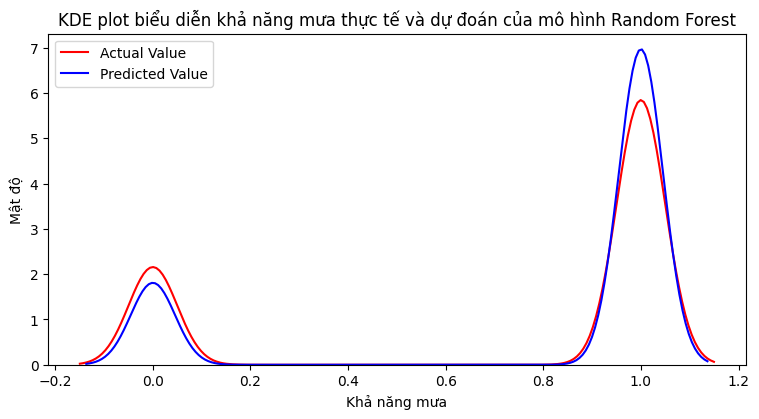

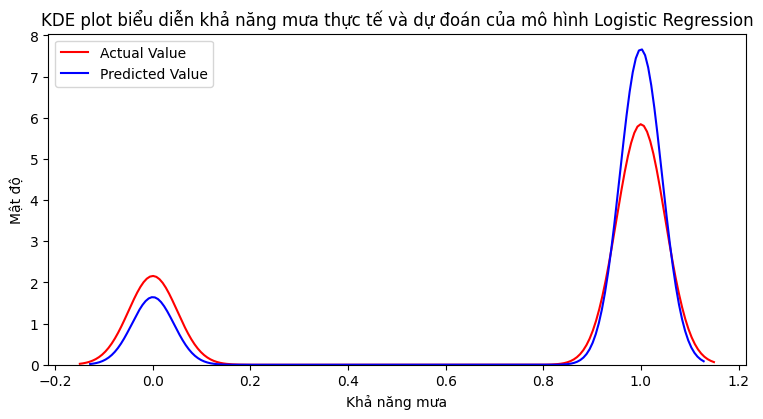

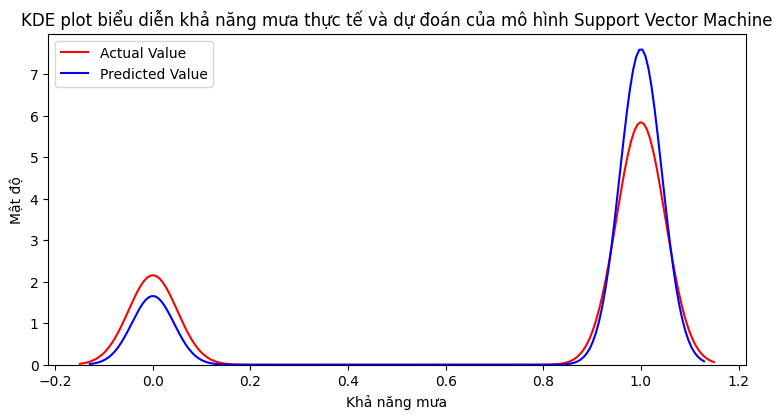

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# Chuyển dữ liệu Spark DataFrame sang Pandas DataFrame
# Giả định 'test_data' có cột 'label' chứa giá trị thực tế
y_test_pd = test_data.select("will_it_rain_24h").toPandas()

# Chuyển dữ liệu dự đoán sang Pandas DataFrame
predictions_rf_pd = predictions_rf.select("prediction").toPandas()
predictions_lr_pd = predictions_lr.select("prediction").toPandas()
predictions_svm_pd = predictions_svm.select("prediction").toPandas()

# Tạo từ điển với dữ liệu dự đoán
predictions_dict = {"Random Forest": predictions_rf_pd['prediction'],
                    "Logistic Regression": predictions_lr_pd['prediction'],
                   "Support Vector Machine": predictions_svm_pd['prediction']}

# Vẽ biểu đồ
for model, dataPred in predictions_dict.items():
    fig, ax1 = plt.subplots(figsize=(9, 4.3))

    ax1 = sns.kdeplot(y_test_pd['will_it_rain_24h'], fill=False, color='r', label="Actual Value")
    sns.kdeplot(dataPred, fill=False, color='b', label="Predicted Value", ax=ax1)

    ax1.set_title(f"KDE plot biểu diễn khả năng mưa thực tế và dự đoán của mô hình {model}")

    plt.xlabel('Khả năng mưa')
    plt.ylabel('Mật độ')
    plt.legend()
    plt.show()

In [38]:
# # prompt: Kết nối với google drive cho tôi với.

# from google.colab import drive
# drive.mount('/content/drive')


In [39]:
# # prompt: Xuất ra file indexer và file 3 model cho tôi với

# import os

# # Define the directory where you want to save the files
# output_dir = "/content/drive/My Drive/SparkModels"
# os.makedirs(output_dir, exist_ok=True)

# # Save the indexer
# indexer_path = os.path.join(output_dir, "condition_text_indexer")
# indexer.save(indexer_path)
# print(f"StringIndexer model saved to: {indexer_path}")

# # Save the Random Forest model
# rf_model_path = os.path.join(output_dir, "random_forest_model")
# model_rf.save(rf_model_path)
# print(f"Random Forest model saved to: {rf_model_path}")

# # Save the Logistic Regression model
# lr_model_path = os.path.join(output_dir, "logistic_regression_model")
# model_lr.save(lr_model_path)
# print(f"Logistic Regression model saved to: {lr_model_path}")

# # Save the Linear SVM model
# svm_model_path = os.path.join(output_dir, "linear_svm_model")
# model_svm.save(svm_model_path)
# print(f"Linear SVM model saved to: {svm_model_path}")